<a href="https://colab.research.google.com/github/linzeQueen/PR/blob/main/pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
pip install pandas numpy scikit-learn matplotlib seaborn

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

# Настройка визуализации
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Подключение Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Загрузка данных
file_path = '/content/drive/MyDrive/Online Retail.xlsx'


df = pd.read_excel(file_path)
print(f"Загружено строк: {df.shape[0]}, колонок: {df.shape[1]}")
print(df.head(3))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Загружено строк: 541909, колонок: 8
  InvoiceNo StockCode                         Description  Quantity  \
0    536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                 WHITE METAL LANTERN         6   
2    536365    84406B      CREAM CUPID HEARTS COAT HANGER         8   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  


In [38]:
data = df.copy()
data = data.dropna(subset=['CustomerID'])
data = data[(data['Quantity'] > 0)]
data = data.drop_duplicates()

#Конвертация типов (ID в int, дату в datetime)
data['CustomerID'] = data['CustomerID'].astype(int)
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['TotalSum'] = data['Quantity'] * data['UnitPrice']

print(f"Данные после очистки: {data.shape}")

Данные после очистки: (392732, 9)


In [39]:
# Дата отсчета = последняя дата в базе + 1 день
snapshot_date = data['InvoiceDate'].max() + dt.timedelta(days=1)

# Агрегация данных по клиентам
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
    'InvoiceNo': 'nunique',                                 # Frequency
    'TotalSum': 'sum'                                       # Monetary
})

# Переименование колонок
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSum': 'Monetary'
}, inplace=True)

rfm.head()
rfm.describe()

,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000
mean,92.518322,4.271952,2048.215924
std,100.009747,7.705493,8984.248352
min,1.000000,1.000000,0.000000
25%,18.000000,1.000000,306.455000
50%,51.000000,2.000000,668.560000
75%,142.000000,5.000000,1660.315000
max,374.000000,210.000000,280206.020000


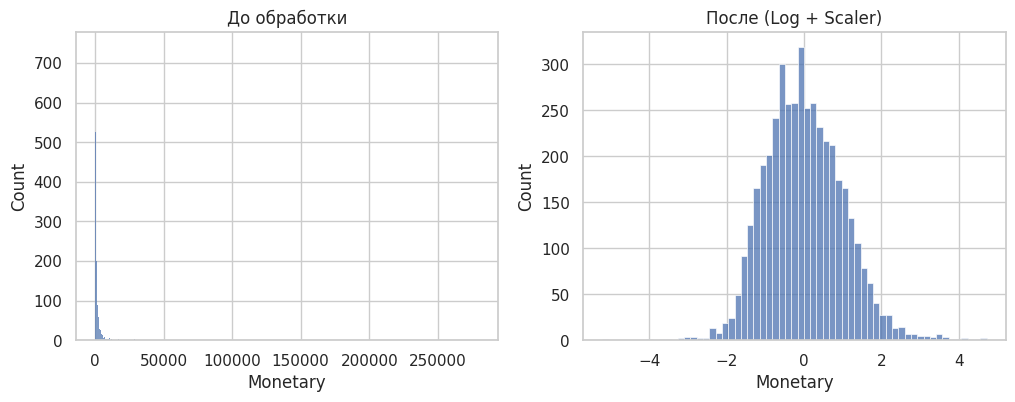

In [40]:
# Логарифмирование (log + 1) для сглаживания выбросов
rfm_log = np.log1p(rfm)

# Стандартизация (Z-score normalization)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

rfm_scaled_df = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1); sns.histplot(rfm['Monetary']); plt.title('До обработки')
plt.subplot(1, 2, 2); sns.histplot(rfm_scaled_df['Monetary']); plt.title('После (Log + Scaler)')
plt.show()

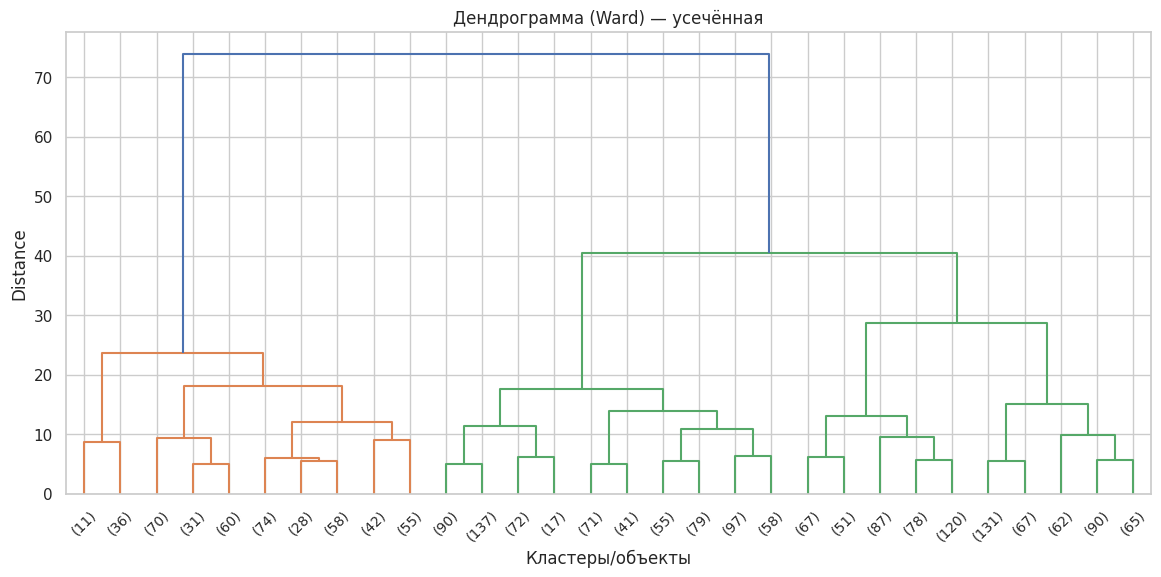

In [41]:
# Дендрограмма (иерархическая кластеризация)
sample_n = min(2000, rfm_scaled_df.shape[0])
sample_idx = np.random.RandomState(42).choice(rfm_scaled_df.index, size=sample_n, replace=False)
X_sample = rfm_scaled_df.loc[sample_idx].values

Z = linkage(X_sample, method="ward")

plt.figure(figsize=(14, 6))
dendrogram(Z, truncate_mode="lastp", p=30, leaf_font_size=10)
plt.title("Дендрограмма (Ward) — усечённая")
plt.xlabel("Кластеры/объекты")
plt.ylabel("Distance")
plt.show()

In [42]:
# Иерархическая кластеризация (Agglomerative) на 3 кластера, linkage=ward
agg = AgglomerativeClustering(n_clusters=3, linkage="ward")
rfm["Cluster_Hier"] = agg.fit_predict(rfm_scaled)

# Оценка качества разбиения (Silhouette Score)
sil_h = silhouette_score(rfm_scaled, rfm["Cluster_Hier"])
print(f"Hierarchical (Agglomerative) Silhouette Score: {sil_h:.3f}")

# Сводка по кластерам: средние RFM и количество клиентов
summary_h = rfm.groupby("Cluster_Hier").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": ["mean", "count"]
}).round(2)

display(summary_h)

Hierarchical (Agglomerative) Silhouette Score: 0.247


Recency Frequency Monetary      
                mean      mean     mean count
Cluster_Hier                                 
0              61.31      2.97  1247.52  2817
1              10.66     15.23  8674.58   592
2             239.15      1.25   255.49   930

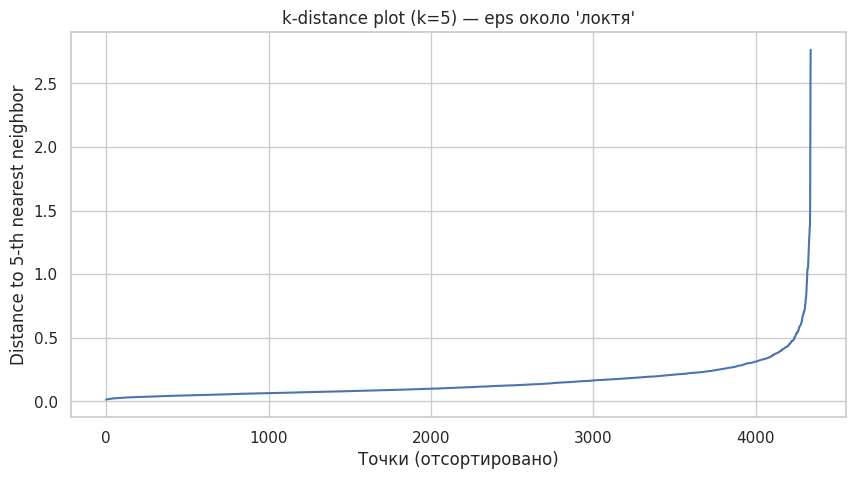

In [43]:
# Подбор eps для DBSCAN через k-distance plot (k = min_samples)
min_samples = 5
k = min_samples

nn = NearestNeighbors(n_neighbors=k)
nn.fit(rfm_scaled)

distances, _ = nn.kneighbors(rfm_scaled)
k_dist = np.sort(distances[:, k-1])

plt.figure(figsize=(10, 5))
plt.plot(k_dist)
plt.title(f"k-distance plot (k={k}) — eps около 'локтя'")
plt.xlabel("Точки (отсортировано)")
plt.ylabel(f"Distance to {k}-th nearest neighbor")
plt.show()

In [44]:
# Перебор нескольких значений eps для DBSCAN и выбор лучшего по silhouette (без шума)
eps_candidates = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
min_samples = 5

results = []
best = None

for eps in eps_candidates:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(rfm_scaled)
    # Число кластеров (без метки шума -1) и количество шумовых точек
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = int(np.sum(labels == -1))
    # Silhouette считаем только если получилось >= 2 кластеров
    sil = np.nan
    if n_clusters >= 2:
        mask = labels != -1
        sil = silhouette_score(rfm_scaled[mask], labels[mask])

    results.append((eps, n_clusters, n_noise, sil))
    # Лучший вариант по silhouette (среди non-noise)
    if n_clusters >= 2 and not np.isnan(sil):
        if best is None or sil > best[3]:
            best = (eps, n_clusters, n_noise, sil)

res_df = pd.DataFrame(results, columns=["eps", "n_clusters", "n_noise", "silhouette_non_noise"])
display(res_df)

print("Лучший (по silhouette среди не-шума):", best)

,eps,n_clusters,n_noise,silhouette_non_noise
0,0.3,8,244,0.063989
1,0.4,6,99,0.066955
2,0.5,2,63,0.293020
3,0.6,2,34,0.566874
4,0.7,2,27,0.563939
5,0.8,1,22,NaN
6,0.9,1,14,NaN


Лучший (по silhouette среди не-шума): (0.6, 2, 34, np.float64(0.5668738448180399))


In [45]:
# Берём eps из best (предполагаем, что best всегда найден)
chosen_eps = best[0]

# Обучаем DBSCAN с выбранным eps
dbscan = DBSCAN(eps=chosen_eps, min_samples=5)
rfm["Cluster_DBSCAN"] = dbscan.fit_predict(rfm_scaled)

# Число кластеров (без шума -1) и шумовые точки
labels = rfm["Cluster_DBSCAN"].values
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = int(np.sum(labels == -1))

print(f"DBSCAN eps={chosen_eps}: clusters={n_clusters}, noise={n_noise}")

# Silhouette считаем только по точкам не-шума
mask = labels != -1
sil_db = silhouette_score(rfm_scaled[mask], labels[mask])
print(f"DBSCAN Silhouette (non-noise): {sil_db:.3f}")

display(rfm["Cluster_DBSCAN"].value_counts())


DBSCAN eps=0.6: clusters=2, noise=34
DBSCAN Silhouette (non-noise): 0.567


,count
Cluster_DBSCAN,
0,4300
-1,34
1,5


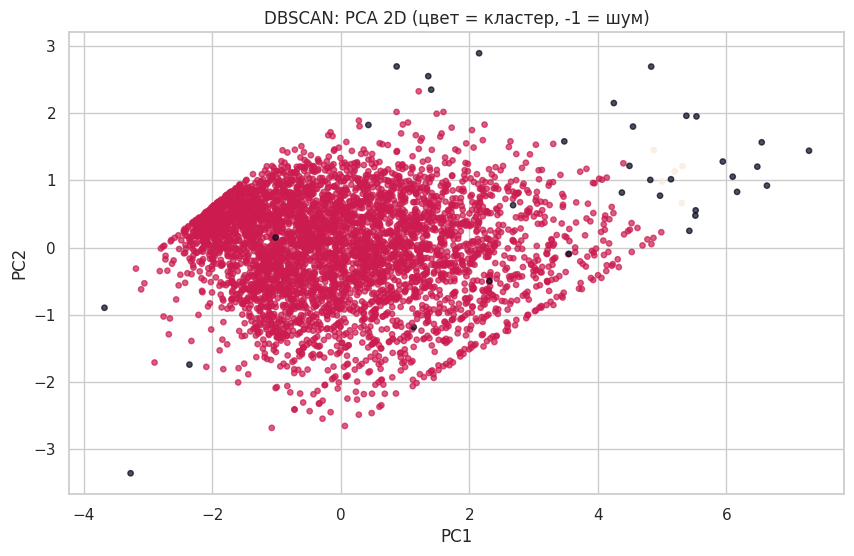

In [46]:
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=rfm["Cluster_DBSCAN"], s=15, alpha=0.7)
plt.title("DBSCAN: PCA 2D (цвет = кластер, -1 = шум)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [47]:
# Убираем шум (метка -1) и строим сводку по оставшимся кластерам
df_db = rfm[rfm["Cluster_DBSCAN"] != -1].copy()

summary_db = df_db.groupby("Cluster_DBSCAN").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": ["mean", "count"]
}).round(2)

display(summary_db)


Recency Frequency  Monetary      
                  mean      mean      mean count
Cluster_DBSCAN                                  
0                92.88      3.88   1492.83  4300
1                 4.40     50.20  47269.74     5

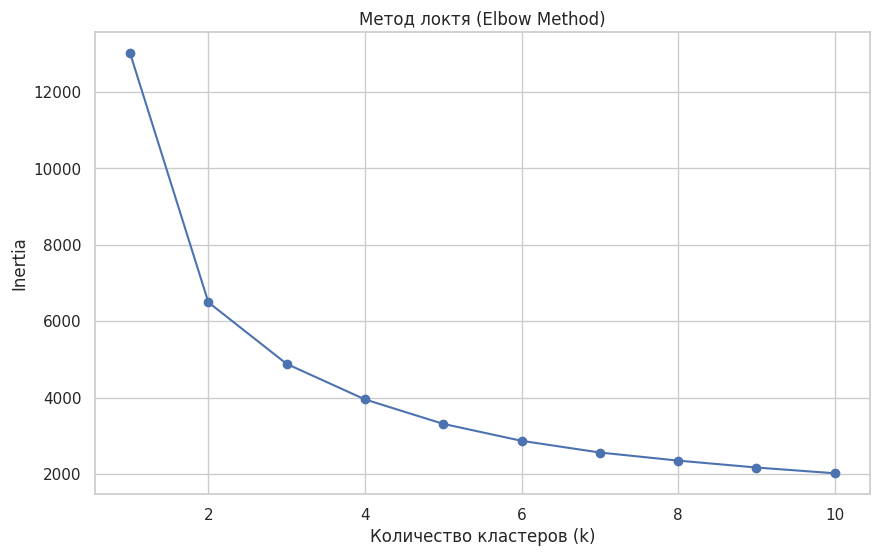

In [48]:
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Inertia')
plt.title('Метод локтя (Elbow Method)')
plt.show()

In [49]:
# Обучение финальной модели
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Оценка качества (Silhouette Score)
sil_score = silhouette_score(rfm_scaled, kmeans.labels_)
print(f"Silhouette Score: {sil_score:.3f}")

# Интерпретация (средние значения по группам)
summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(2)

summary

Silhouette Score: 0.336


Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0        167.21      1.35   359.38  1870
1         16.62     13.37  7909.07   766
2         44.65      3.39  1266.49  1703

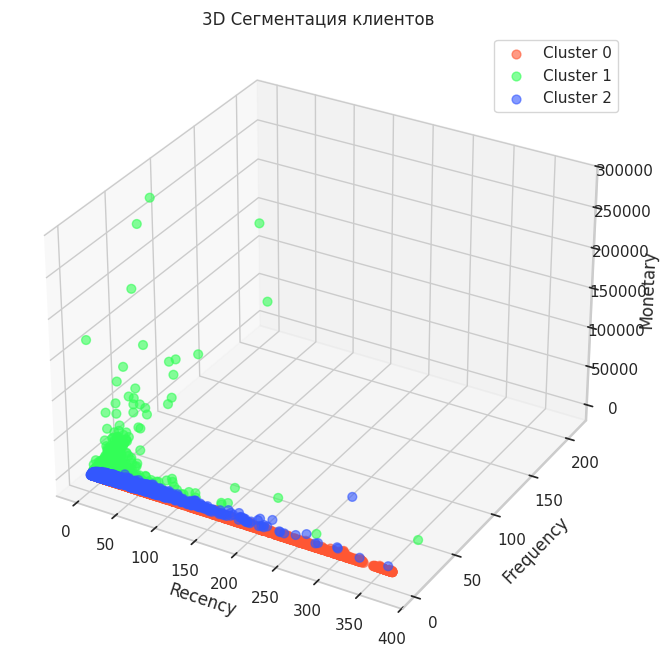

In [50]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['#FF5733', '#33FF57', '#3357FF']

for i in range(3):
    subset = rfm[rfm['Cluster'] == i]
    ax.scatter(subset['Recency'], subset['Frequency'], subset['Monetary'],
               c=colors[i], label=f'Cluster {i}', s=40, alpha=0.6)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3D Сегментация клиентов')
plt.legend()
plt.show()

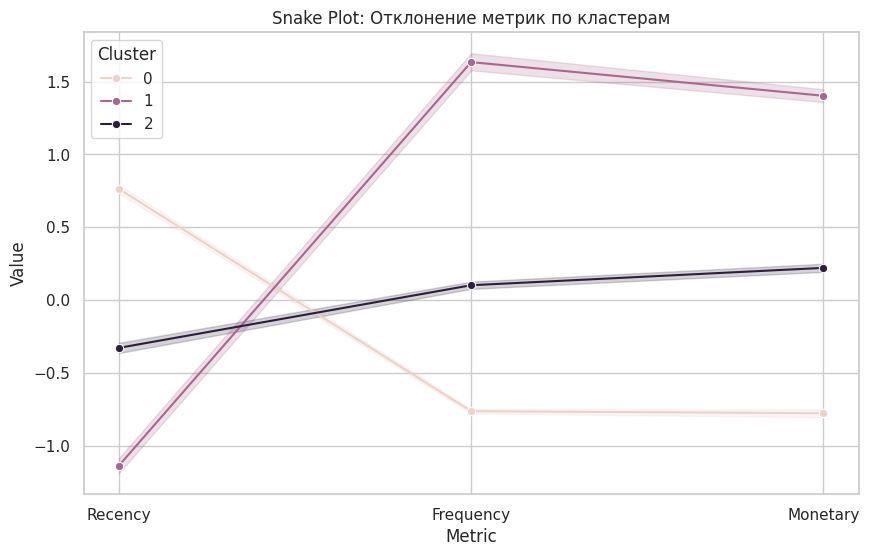

In [51]:
rfm_melted = pd.melt(rfm_scaled_df.assign(Cluster=rfm['Cluster']),
                     id_vars=['Cluster'],
                     var_name='Metric',
                     value_name='Value')

plt.figure(figsize=(10, 6))
sns.lineplot(x='Metric', y='Value', hue='Cluster', data=rfm_melted, marker="o")
plt.title('Snake Plot: Отклонение метрик по кластерам')
plt.show()